<a href="https://colab.research.google.com/github/armiro/canine-disease-diagnosis/blob/main/model_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## libraries and data importing

In [ ]:
# update sklearn package to v0.24.x which is the latest version
!pip install --upgrade scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
dataset = pd.read_csv("/content/canine_chemical_dataset_v1.6.csv")
print(dataset.head())

features = dataset.iloc[:, :30]
labels = dataset.iloc[:, 30:]

              Species   Age  ... Volume depletion  hepatocellular injury
0       HERDING GROUP  10.0  ...                0                      0
1  NON-SPORTING GROUP  13.0  ...                0                      0
2       WORKING GROUP   1.0  ...                0                      0
3       HERDING GROUP   6.0  ...                0                      0
4       HERDING GROUP   3.0  ...                0                      0

[5 rows x 244 columns]


## EDA: feature investigation and correlation detection

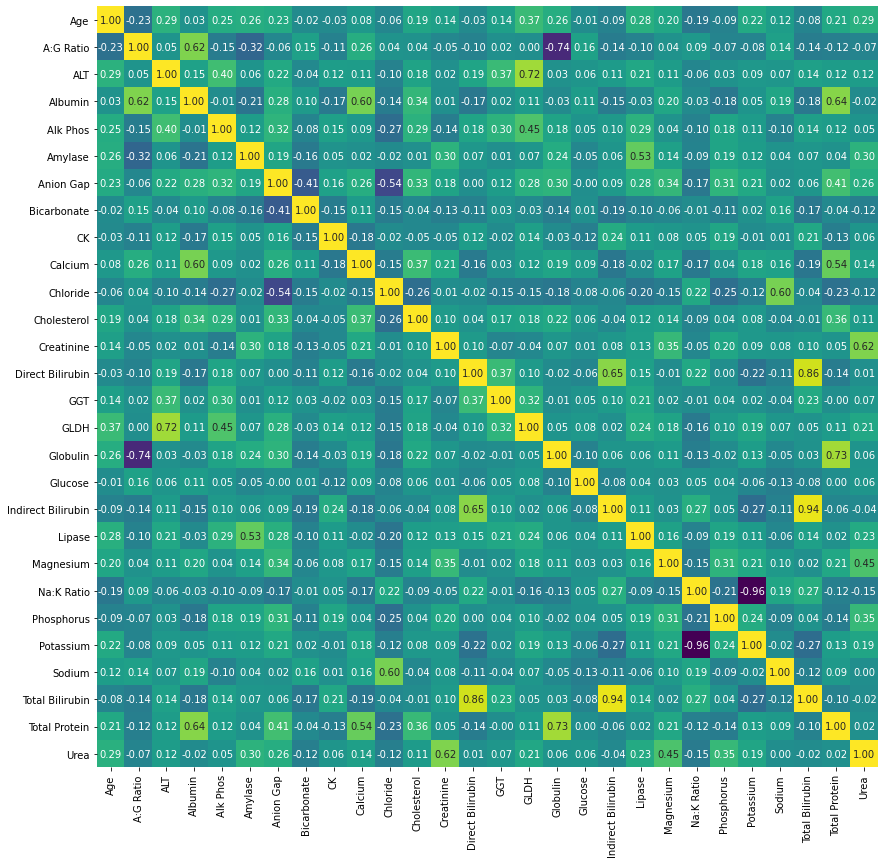

In [55]:
corr_mat = features.corr()
fig = plt.figure(figsize=(14, 14))
sns.heatmap(corr_mat, xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, 
            cmap='viridis', annot=True, fmt='.2f', cbar=False)

0.8582230246285201 13 25


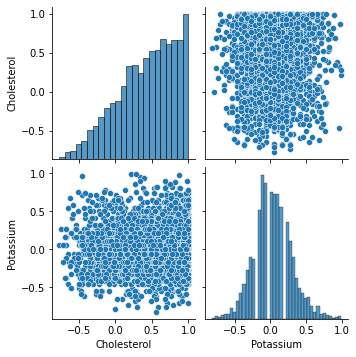

0.9360213854704039 18 25


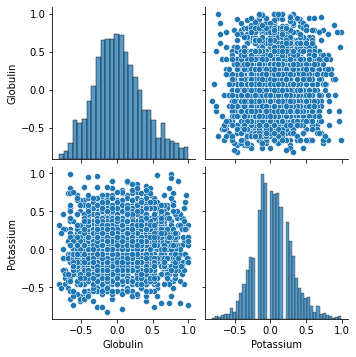

-0.9610578605091974 21 23


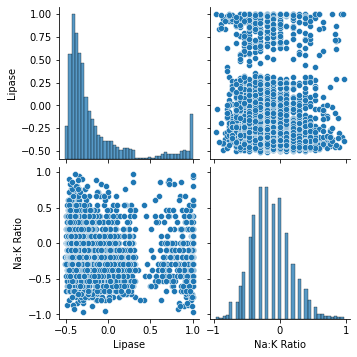

-0.9610578605091974 23 21


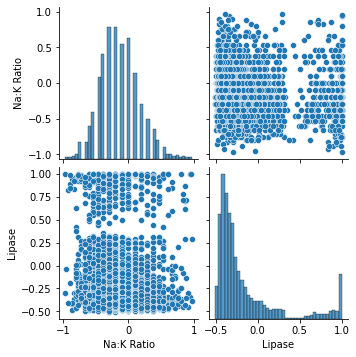

0.8582230246285201 25 13


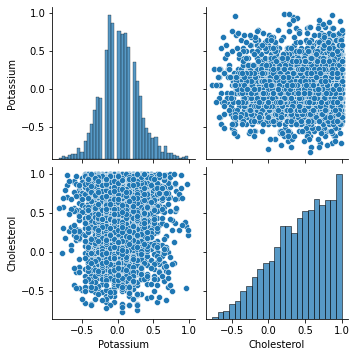

0.9360213854704039 25 18


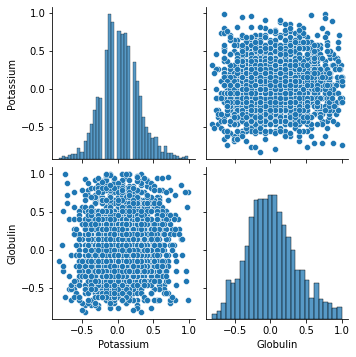

In [110]:
for r_idx, row in enumerate(corr_mat.values):
    for c_idx, e in enumerate(row):
        if ((e >= 0.75) | (e <= -0.75)) & (r_idx != c_idx):
            print(e, r_idx, c_idx)
            sub_df = features[[features.columns[r_idx], features.columns[c_idx]]]
            sns.pairplot(sub_df)
            plt.show()

## EDA: label investigation and reduction strategies

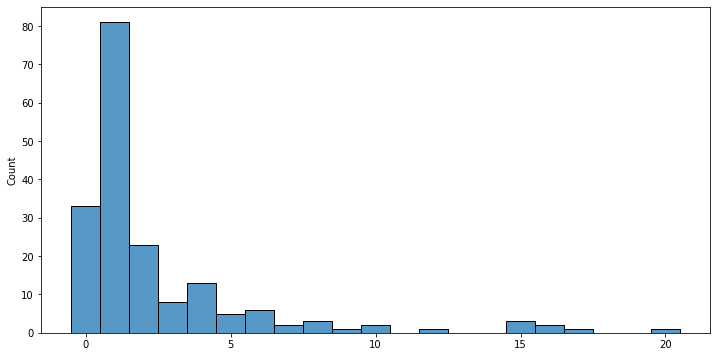

In [ ]:
# one last prep step for labels: we have too many (214) labels which could be shrunken
# to much smaller number of labels. we have to let go of labels with few occurances
label_freqs_list = list()
label_names = list()
for label, column in labels.iteritems():
    label_names.append(label)
    label_freqs_list.append(np.sum(column))

fig = plt.figure(figsize=(12, 6))
sns.histplot(data=label_freqs_list, discrete=True, binrange=(0, 20)) # hist for least frequent
plt.show()
# which threshold? we can omit labels with freq < 5 (we can change later to see differences)

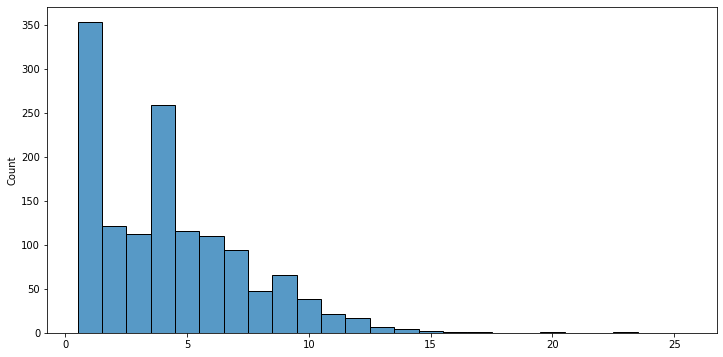

In [ ]:
# having labels that never happen (freq = 0) is weird. Let's see how many labels are
# activated for each record
num_activated_labels = list()
for row_idx, row in labels.iterrows():
    num_activated_labels.append(np.sum(row))

fig = plt.figure(figsize=(12, 6))
sns.histplot(data=num_activated_labels, discrete=True, binrange=(1, 25))
plt.show()

In [ ]:
drop_list = list()
for label, column in labels.iteritems():
    if np.sum(column) < 5: # omit labels with less than 5 occurances
        drop_list.append(label)

labels = labels.drop(columns=drop_list).values
print('number of labels is reduced from %d to %d' % (len(label_names), len(labels[0])))

number of labels is reduced from 214 to 56


## final prep & model development

In [ ]:
onehot_encoder_1 = OneHotEncoder(categories='auto', drop='first', sparse=False)
encoded_mat_1 = onehot_encoder_1.fit_transform(X=features[:, 0].reshape(-1, 1))

onehot_encoder_2 = OneHotEncoder(categories='auto', drop='first', sparse=False)
encoded_mat_2 = onehot_encoder_2.fit_transform(X=features[:, 2].reshape(-1, 1))

features = np.concatenate((encoded_mat_1, features[:, 1].reshape(-1, 1), 
                               encoded_mat_2, features[:, 3:]), axis=1)

In [ ]:
features[:, 7] = features[:, 7] / np.max(features[:, 7]) # downscale 'age' to [0,1]

# split the dataset into training-set and test-set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=17)

In [ ]:
# perform outlier detection using automated methods


In [ ]:
from sklearn.neural_network import MLPClassifier

# class weights?
classifier = MLPClassifier(hidden_layer_sizes=(100, 10,), activation='relu', solver='adam',
                           max_iter=2500, verbose=1)

In [ ]:
classifier.fit(X=X_train, y=y_train)

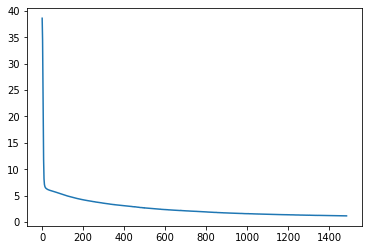

In [ ]:
plt.plot(classifier.loss_curve_)
plt.show()

In [ ]:
idx = np.random.randint(0, len(X_train))
print(idx)
print(classifier.predict(X=np.expand_dims(X_train[idx], axis=0)))
print(y_train[idx])

142
[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## result visualization and discussion

In [ ]:
from sklearn.metrics import confusion_matrix

